# Analysis of raw dataset fisher/fe_03_p1m

## Sourcing information

### Where does the data come from?

> **NOTE**
>
> This is a subset of the original fisher/fe_03_p1 dataset.
> More specifically:
> - only AUDIO available is the `.../disc1/` group
> - however, all the LABELS are available, mainly for analysis

The corpus is the first half of a collection of conversational telephone speech (CTS) created at LDC during 2003.

It contains **5850** audio files, each with one full conversation of **upto 10 minutes** between **2 participants**.

**Origin Location on disk**

- `AUDIO`
    + `/nm-raid/audio/data/corpora/LDC/fisher_eng_tr_sp_LDC2004S13/fisher_eng_tr_sp_LDC2004S13.zip`
- `LABELS`
    + `/nm-raid/audio/data/corpora/LDC/Other/LDC2004T19.tgz`
    
The raw files were copied into `$RENNET_ROOT/data/raw/fisher/fe_03_p1m/`

The audio files are NIST Sphere files (.sph), with two channels, one per speaker, (0: A, 1: B). 
The files are grouped into directories of a 100 files each with name representing the first 3 significant digits of the 5-digit callids of the files in the group.
The groups are available on 7 different discs, with mostly 8 per disc. The discs are named as `discN` with N from 1 to 7.
The `filetable.txt` has complete listing of all the files in this part of the dataset, including the gender of the speakers.
See below for details of the files that were kept with judgment of their utility in our task.

The labels come in two forms: One that was extracted in an automated way marking speech parts, in `data/bbn_orig/`.
The relevant transcription is in `data/trans/`, which are txt files in groups of 100 files as above.
The labels are however not divided based on discs.
The `doc` folder has useful readmes and metadata for the recordings, with more information about the conversation and the speakers involved.

### Copying files to `working` folder

The copying was done **MANUALLY**, to `$RENNET_ROOT/data/working/fisher/fe_03_p1m/raw` with the following modifications.

- `AUDIO`
    + has the readme file, and the `filetable.txt` with list of all audio files, and corresponding speaker genders
    + `data/disc1` to `data/disc7` with grouped audio sph files, each group having roughly a hundred of them.
        * the groups are named based on the first 3 digits of the conversation IDs of the files in them.
- `LABELS`
    + has readmes and doc files with more info about the transcriptions and the metadata in the same folder
        * `fe_03_p1_calldata.tbl` has most of the relevant speaker and annotation metadata
        * `fe_03_pindata.tbl` has deeper information about the speaker themselves.
        * `fe_03_topics.sgm` is an xml like file with the information about the topics of conversation, referred in the `calldata` file
    + Same as above, `data/disc1` to `data/disc7` with grouped transcription txt files, each group having roughly a hundred of them.
        * the groups are named based on the first 3 digits of the conversation IDs of the files in them.

## Imports and finding filepaths

### Imports

In [1]:
from __future__ import print_function, division

import os
import sys

rennet_root = os.environ['RENNET_ROOT']
sys.path.append(rennet_root)

%load_ext autoreload
%autoreload 1

In [2]:
import glob
import numpy as np
from collections import defaultdict
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-muted')

In [3]:
# rennet specific imports
# autoreload for debugging
%aimport rennet.datasets.fisher
import rennet.datasets.fisher as fe

### Gather all audio, labels and calldata filepaths

> **NOTE**
>
> If it is not clear by now, we will be, from now on, working exclusively with the working directory we created earlier. Keep that in mind for all the instructions to come.

***

> **NOTE**
>
> `fisher/fe_03_p1m` does not have all the audio files.
> But all the labels are available for analysis


In [4]:
# Making glob queries for audio, label and calldata files

# UPDATE HERE - BEGIN #######################################################

rennet_working_dir = os.path.join(rennet_root, 'data', 'working')

provider = 'fisher'
dataset = 'fe_03_p1m'
rennet_working_raw_dir = os.path.join(rennet_working_dir, 
                                      provider, dataset, 'raw')

raw_audio_dir = os.path.join(rennet_working_raw_dir, 'audio', 'data')
raw_audio_groups_glob_str = str(os.path.join(raw_audio_dir, "*", "*"))

raw_labels_dir = os.path.join(rennet_working_raw_dir, 'labels', 'data')
raw_labels_groups_glob_str = str(os.path.join(raw_labels_dir, "*", "*"))

raw_calldata_glob_str = str(os.path.join(rennet_working_raw_dir, 
                                         'labels', "*calldata.tbl"))

expected_audio_groups = 8
expected_labels_groups = 59

# UPDATE HERE - END #########################################################

print("Audio Groups Query:\n", raw_audio_groups_glob_str)
print()
print("Labels Groups Query:\n", raw_labels_groups_glob_str)
print()
print("Calldata Query:\n", raw_calldata_glob_str)
print()

Audio Groups Query:
 /Users/abdullah/Delve/iais/rennet/data/working/fisher/fe_03_p1m/raw/audio/data/*/*

Labels Groups Query:
 /Users/abdullah/Delve/iais/rennet/data/working/fisher/fe_03_p1m/raw/labels/data/*/*

Calldata Query:
 /Users/abdullah/Delve/iais/rennet/data/working/fisher/fe_03_p1m/raw/labels/*calldata.tbl



In [5]:
# Finding audio and label files in each group and matching pairs

audio_groups_dirs = sorted(glob.glob(raw_audio_groups_glob_str))
audio_fps = [sorted(glob.glob(os.path.join(gd, '*.sph'))) for gd in audio_groups_dirs]

label_groups_dirs = sorted(glob.glob(raw_labels_groups_glob_str))
label_fps = [sorted(glob.glob(os.path.join(gd, '*.txt'))) for gd in label_groups_dirs]

print("AUDIO:###########################################################\n\n", 
      "{} Groups".format(len(audio_groups_dirs)), 
      "{} Total Files, as:\n\n".format(sum(map(len, audio_fps))), list(map(len, audio_fps)),
      "\n\nFor Example:\n\n{}\n...".format("\n".join(audio_fps[0][:5])))
print()

if len(audio_groups_dirs) != expected_audio_groups:
    warnings.warn("\nNot all audio groups were found")
    
print("LABEL:###########################################################\n\n", 
      "{} Groups".format(len(label_groups_dirs)), 
      "{} Total Files, as:\n\n".format(sum(map(len, label_fps))), list(map(len, label_fps)),
      "\n\nFor Example:\n\n{}\n...".format("\n".join(label_fps[0][:5])))
print()

if len(label_groups_dirs) != expected_labels_groups:
    warnings.warn("\nNot all label groups were found")
    
    
def callid_from_fp(fp):
    return os.path.basename(fp).split('_')[-1].split('.')[0]


# find if there are all groups
if len(audio_groups_dirs) != len(label_groups_dirs):
    warnings.warn("\nMismatch in number of audio and label groups:"
                  "\nAudios {} v/s {} Labels".format(
                      len(audio_groups_dirs), 
                      len(label_groups_dirs)))

# NOTE: The following checks use zip for matching and assume order
# if the first n of the total N groups or files are available, there will be no warning
# if the n groups or files are from somewhere in the middle, there will be mismatch

# find if certain groups mismatch
if any(lag != llg for lag, llg in zip(map(len, audio_fps), map(len, label_fps))):
    warnings.warn("\nMismatch in number of files in certain groups")

# check if each pair has the same callid
audio_callids = [map(callid_from_fp, fps) for fps in audio_fps]
label_callids = [map(callid_from_fp, fps) for fps in label_fps]

if any(any(ac != lc for ac, lc in zip(gac, glc)) for gac, glc in zip(audio_callids, label_callids)):
    warnings.warn("\nMismatch in callids for certain files")
        

AUDIO:###########################################################

 8 Groups 799 Total Files, as:

 [99, 100, 100, 100, 100, 100, 100, 100] 

For Example:

/Users/abdullah/Delve/iais/rennet/data/working/fisher/fe_03_p1m/raw/audio/data/disc1/000/fe_03_00001.sph
/Users/abdullah/Delve/iais/rennet/data/working/fisher/fe_03_p1m/raw/audio/data/disc1/000/fe_03_00002.sph
/Users/abdullah/Delve/iais/rennet/data/working/fisher/fe_03_p1m/raw/audio/data/disc1/000/fe_03_00003.sph
/Users/abdullah/Delve/iais/rennet/data/working/fisher/fe_03_p1m/raw/audio/data/disc1/000/fe_03_00004.sph
/Users/abdullah/Delve/iais/rennet/data/working/fisher/fe_03_p1m/raw/audio/data/disc1/000/fe_03_00005.sph
...

LABEL:###########################################################

 59 Groups 5850 Total Files, as:

 [99, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 10

/Users/abdullah/anaconda3/envs/r3/lib/python3.5/site-packages/ipykernel/__main__.py:37: UserWarning: 
Mismatch in number of audio and label groups:
Audios 8 v/s 59 Labels


In [6]:
# Finding the calldata.tbl file

calldata_fp = glob.glob(raw_calldata_glob_str)

if len(calldata_fp) > 1:
    warnings.warn("More than one calldata file found")
elif len(calldata_fp) < 1:
    warnings.warn("Calldata file was not found")
else:
    calldata_fp = calldata_fp[0]
    print("CALLDATA filepath: ", calldata_fp)

CALLDATA filepath:  /Users/abdullah/Delve/iais/rennet/data/working/fisher/fe_03_p1m/raw/labels/fe_03_p1_calldata.tbl


## Read the calldata, annotations and activespeakers

`rennet.dataset.fisher` (== `fe`) has implementations of classes to work with the label files.

> **NOTE**
>
> It is **explicitly and implicitly assumed** that the labels for this dataset always have two speakers, one per channel.
> 
> The first channel has been annotated as 'A', and the second one as 'B'.
> This explicit assumption is used in certain properties, or order of objects.
>
> Where it has been foreseen, an error will be raised if this assumption breaks. 

### Fisher Calldata

`fe.FisherAllCalldata` reads all the call data from the calldata.tbl file and stores in a list `allcalldata`.

For each call, the following information is read:

```
FisherCallData (
    - callid
    - topicid
    - signalgrade
    - convgrade
    - [
        + FisherChannelSpeaker A (
            * id
            * gender
            * dialect
            * phone_service
          )
        + FisherChannelSpeaker B ( ... )
    ]
)
```

More information about what these quantities represent can be obtained in the readme file `doc_calldata_tbl.txt`.
You are also welcome to look at the source code of the class, since only some information is covered here.

The class has an index for the calldata based on `callid`.

An instance of this class can be created by simply passing the filepath to a valid calldata.tbl to it's `from_file` classmethod.

In [7]:
calldatas = fe.FisherAllCallData.from_file(calldata_fp)

print("CALLDATA read for {} callids".format(len(calldatas.allcalldata)))
print("\nExample calldata:\n")
print(calldatas.calldata_for_callid('00434'), sep='\n')

CALLDATA read for 5850 callids

Example calldata:

FisherCallData(callid='00434', topicid='ENG30', signalgrade=4.0, convgrade=4.0, channelspeakers=[FisherChannelSpeaker(id='2872', gender='f', dialect='a', phone_service='2'), FisherChannelSpeaker(id='5019', gender='f', dialect='a', phone_service='2')])


### Fisher Annotations

`fe.FisherAnnotations` reads the all the annotations for all the timesegments of a call from it's corresponding label file.
It is a specialization of the `SequenceLabels` class, which assumes non-contigious labels per time segment (overlaps are expected).

The label files are text files, with start time, end time, channel and content per annotation of a (speech) segment in time.
These are read into the `SequenceLabels` data structure, with each row of the `starts_ends` array representing the start and end times, and each row of the `labels` array having:

```
FisherTranscription (
    - speakerchannel  # Channel number of the speaker
    - content  # of the speech
)
```

Please refer to the source and the `fe_03_readme.txt` for more information.

A new instance of the `FisherAnnotations` class can be created by simply passing the path to the labels file to it's `from_file` method. 

When an instance of `FisherCallData` is also passed to the above method, the relevant calldata for the label's callid will also be stored as a property. But this is optional.


In [8]:
annotations = []
for group_fps in label_fps:
    annotations.append([fe.FisherAnnotations.from_file(fp, allcalldata=calldatas) 
                        for fp in group_fps])

print("ANNOTATIONS read from total {} label files with calldata".format(sum(map(len, annotations))))

ANNOTATIONS read from total 5850 label files with calldata


In [9]:
print("Example Annotation:\n")
ann = annotations[0][0]
with ann.samplerate_as(1.):  # prints start-end times in seconds
    print(ann)

Example Annotation:

Source filepath:
/Users/abdullah/Delve/iais/rennet/data/working/fisher/fe_03_p1m/raw/labels/data/disc1/000/fe_03_00001.txt

Calldata:
FisherCallData(callid='00001', topicid='ENG34', signalgrade=2.0, convgrade=2.0, channelspeakers=[FisherChannelSpeaker(id='2602', gender='m', dialect='a', phone_service='1'), FisherChannelSpeaker(id='1790', gender='f', dialect='a', phone_service='3')])

FisherAnnotations with sample rate: 1.0
Start    - End      : Label
3.7600   - 5.5400   : FisherTranscription(speakerchannel=0, content='and i generally prefer')
5.8200   - 6.4800   : FisherTranscription(speakerchannel=0, content='eating at home')
7.9200   - 9.5200   : FisherTranscription(speakerchannel=1, content='hi my name is andy')
10.0500  - 10.8800  : FisherTranscription(speakerchannel=0, content='hello andy')
11.8200  - 12.3100  : FisherTranscription(speakerchannel=0, content='how are you')
12.4900  - 14.0400  : FisherTranscription(speakerchannel=1, content='good how are you doi

### Fisher Active Speakers

[ ] TODO

In [10]:
activespeakers = []
for group_fps in label_fps:
    activespeakers.append([fe.FisherActiveSpeakers.from_file(fp, 
                                                             warn=False, 
                                                             allcalldata=calldatas)
                           for fp in group_fps])
    
print("ACTIVESPEAKERS read for total {} label files with calldata".format(sum(map(len, activespeakers))))

ACTIVESPEAKERS read for total 5850 label files with calldata


In [11]:
print("Example activespeakers:\n")
act = activespeakers[0][0]
with act.samplerate_as(1.):  # prints start-end times in seconds
    print(act)

Example activespeakers:

Source filepath:
/Users/abdullah/Delve/iais/rennet/data/working/fisher/fe_03_p1m/raw/labels/data/disc1/000/fe_03_00001.txt

Calldata:
FisherCallData(callid='00001', topicid='ENG34', signalgrade=2.0, convgrade=2.0, channelspeakers=[FisherChannelSpeaker(id='2602', gender='m', dialect='a', phone_service='1'), FisherChannelSpeaker(id='1790', gender='f', dialect='a', phone_service='3')])

FisherActiveSpeakers with sample rate: 1.0
Start    - End      : Label
0.0000   - 3.7600   : [0 0]
3.7600   - 5.5400   : [1 0]
5.5400   - 5.8200   : [0 0]
5.8200   - 6.4800   : [1 0]
6.4800   - 7.9200   : [0 0]
7.9200   - 9.5200   : [0 1]
9.5200   - 10.0500  : [0 0]
10.0500  - 10.8800  : [1 0]
10.8800  - 11.8200  : [0 0]
11.8200  - 12.3100  : [1 0]
12.3100  - 12.4900  : [0 0]
12.4900  - 13.5900  : [0 1]
13.5900  - 13.9600  : [1 1]
13.9600  - 14.0400  : [0 1]
14.0400  - 14.4700  : [0 0]
14.4700  - 15.6400  : [1 0]
15.6400  - 15.7300  : [1 1]
15.7300  - 18.5100  : [0 1]
18.5100  - 19

## Durations analysis

> **NOTE**
>
> All the analysis below is done purely based on the durations annotated.
>
> This only guarantees a minimum bound on the duration values, since the silences 
> at the end of the calls are not annotated.
>
> Nevertheless, all speech and double-speech segment durations should be accurate.
>
> More accurate duration values should be extracted from the audio files themselves, 
> especially when the entire dataset is at hand

In [12]:
def split_seconds(seconds):
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)
    return int(h), int(m), round(s, 2)

def print_splitsec(duration, name):
    print("{} : {:10.2f} seconds = {}".format(
        name, duration, 
        "{:4} : {:2} : {:5.2f}".format(*split_seconds(duration))
    ))

### Total Durations - Over files

In [13]:
total_durations_grouped = []
for actg in activespeakers:
    total_durationsg = []
    for act in actg:
        with act.samplerate_as(100):  # max resolution is 1ms, mostly
            total_durationsg.append(int(act.ends[-1]))
    total_durations_grouped.append(np.array(total_durationsg) / 100)
    
file_durations = np.concatenate(total_durations_grouped)

In [14]:
print("Audio Durations")
print_splitsec(np.sum(file_durations),   "Total   ")
print_splitsec(np.min(file_durations),   "Minimum ")
print_splitsec(np.max(file_durations),   "Maximum ")
print_splitsec(np.mean(file_durations),  "Mean    ")
print_splitsec(np.std(file_durations),   "Std     ")

Audio Durations
Total    : 3482482.03 seconds =  967 : 21 : 22.03
Minimum  :     339.43 seconds =    0 :  5 : 39.43
Maximum  :     719.96 seconds =    0 : 11 : 59.96
Mean     :     595.30 seconds =    0 :  9 : 55.30
Std      :      32.99 seconds =    0 :  0 : 32.99


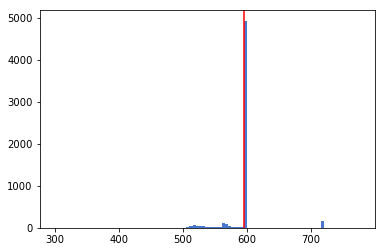

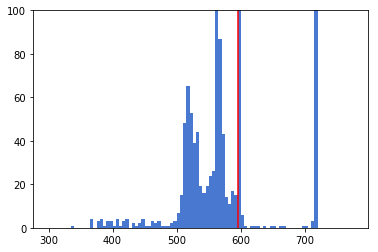

In [15]:
duration_bins = np.arange(300, 780, 5)  # every 5 seconds, till 13 minutes

plt.figure()
_ = plt.hist(file_durations, bins=duration_bins,)
plt.axvline(file_durations.mean(), c='r')  # MEAN in RED

# avoid clipping
plt.figure()
_ = plt.hist(file_durations, bins=duration_bins,)
plt.ylim([0, 100])
plt.axvline(file_durations.mean(), c='r')  # MEAN in RED

#### Results

[ ] TODO

### Total Durations - Over Groups

In [16]:
group_durations = np.array(list(map(sum, total_durations_grouped)))

In [17]:
print("Group Durations")
print_splitsec(np.sum(group_durations),   "Total   ")
print_splitsec(np.min(group_durations),   "Minimum ")
print_splitsec(np.max(group_durations),   "Maximum ")
print_splitsec(np.mean(group_durations),  "Mean    ")
print_splitsec(np.std(group_durations),   "Std     ")

Group Durations
Total    : 3482482.03 seconds =  967 : 21 : 22.03
Minimum  :   30434.81 seconds =    8 : 27 : 14.81
Maximum  :   63725.15 seconds =   17 : 42 :  5.15
Mean     :   59025.12 seconds =   16 : 23 : 45.12
Std      :    4013.30 seconds =    1 :  6 : 53.30


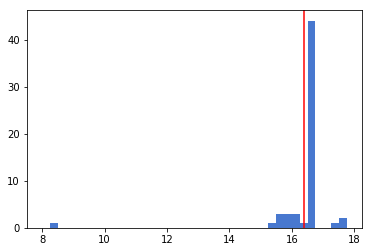

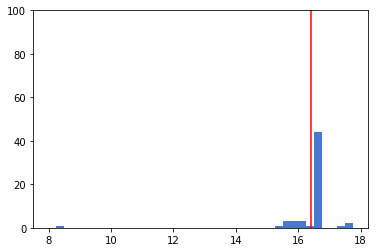

In [18]:
duration_bins = np.arange(8, 18, 15/60)  # every 15 minutes, till 18 hours

plt.figure()
_ = plt.hist(group_durations/3600, bins=duration_bins,)
plt.axvline(group_durations.mean()/3600, c='r')  # MEAN in RED

# avoid clipping
plt.figure()
_ = plt.hist(group_durations/3600, bins=duration_bins,)
plt.ylim([0, 100])
plt.axvline(group_durations.mean()/3600, c='r')  # MEAN in RED


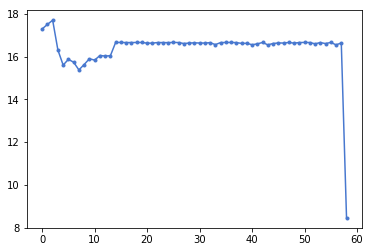

In [19]:
plt.figure()
plt.plot(group_durations/3600, '-', marker='.')

#### Results

- The last group (059) is half the length, and has fewer files
- All of the groups have similar total durations and 100 files, except the first and last groups which have 99 and 51 files, respectively

### Validation, Train and Test Splits based on group durations

The idea is that, there is so much data, that splitting based just on groups should be enough.

- The variances across the groups are expected to be insignificant, wrt double-talk and it's contributing factors
    + even 1% of the data is in actuality 9 hours long, roughly 10x what ka3 has.
    + [ ] **Needs to be tested** based on those parameters, eg gender-ratios, dt-durations, dt-occurances, recording-conditions, dialects, etc
- It is very easy to assign groups, or even entire discs to a particular split.
    + ***IDEALLY*** this whole thing should be randomized
- Cross-validation on this dataset, even if arguably will be good, it is definitely impractical
    + a 90-10 train-test split seems more than enough, given 10% will be roughly 90 hours
    + Again, **Variances should be tested for** beforehand
- This subset of the dataset only has disc1, so choosing a constant validation set (probably the entire group `000`) would help with continuity
    + The rest of the dataset available will be used for training while on the Mac
    + The test set, probably the entire last disc (`disc7`) would be available at unumpu

In [20]:
val_groups = [0]

tis = 53
tst_groups = list(range(tis, len(group_durations)))

trn_groups = list(filter(lambda v: ((v not in val_groups) and 
                                    (v not in tst_groups)), 
                         range(len(group_durations))))

trn_val_groups = np.concatenate([val_groups, trn_groups])

print("    VAL with {:2} groups and {:4} files".format(len(val_groups), sum(map(len, [activespeakers[i] for i in val_groups]))))
print("    TRN with {:2} groups and {:4} files".format(len(trn_groups), sum(map(len, [activespeakers[i] for i in trn_groups]))))
print("    TST with {:2} groups and {:4} files".format(len(tst_groups), sum(map(len, [activespeakers[i] for i in tst_groups]))))
print("TRN+VAL with {:2} groups and {:4} files".format(len(trn_val_groups), sum(map(len, [activespeakers[i] for i in trn_val_groups]))))

    VAL with  1 groups and   99 files
    TRN with 52 groups and 5200 files
    TST with  6 groups and  551 files
TRN+VAL with 53 groups and 5299 files


In [21]:
print("Train-Test Split - Groups Durations")
print_splitsec(np.sum(group_durations[trn_val_groups]),
               "TRN+VAL: {:5.2f}%".format(100 * group_durations[trn_val_groups].sum()/group_durations.sum()))
print_splitsec(np.sum(group_durations[tst_groups]),
               "TST    : {:5.2f}%".format(100 * group_durations[tst_groups].sum()/group_durations.sum()))

print()
print("Train-Val Split - Groups Durations")
print_splitsec(np.sum(group_durations[trn_groups]),
               "TRN    : {:5.2f}%".format(100 * group_durations[trn_groups].sum()/group_durations[trn_val_groups].sum()))
print_splitsec(np.sum(group_durations[val_groups]),
               "VAL    : {:5.2f}%".format(100 * group_durations[val_groups].sum()/group_durations[trn_val_groups].sum()))


Train-Test Split - Groups Durations
TRN+VAL: 90.53% : 3152817.45 seconds =  875 : 46 : 57.45
TST    :  9.47% :  329664.58 seconds =   91 : 34 : 24.58

Train-Val Split - Groups Durations
TRN    : 98.03% : 3090555.71 seconds =  858 : 29 : 15.71
VAL    :  1.97% :   62261.74 seconds =   17 : 17 : 41.74


In [22]:
disc_name_for_group = lambda fp: os.path.basename(os.path.dirname(fp))
at = lambda l, i: [l[ii] for ii in i]

tst_discs = np.unique(list(map(disc_name_for_group, at(label_groups_dirs, tst_groups))))
trn_discs = np.unique(list(map(disc_name_for_group, at(label_groups_dirs, trn_groups))))
val_discs = np.unique(list(map(disc_name_for_group, at(label_groups_dirs, val_groups))))
trn_val_discs = np.unique(list(map(disc_name_for_group, at(label_groups_dirs, trn_val_groups))))

print("VAL Discs:\n", *val_discs, '\n')
print("TRN Discs:\n", *trn_discs, '\n')
print("TST Discs:\n", *tst_discs, '\n')
print("TRN+VAL Discs:\n", *trn_val_discs, '\n')

VAL Discs:
 disc1 

TRN Discs:
 disc1 disc2 disc3 disc4 disc5 disc6 

TST Discs:
 disc7 

TRN+VAL Discs:
 disc1 disc2 disc3 disc4 disc5 disc6 



#### Results

- Assigning all groups from `disc7` to test set affords >91 hours of data, around 9.5% of total
    + The rest of the dataset is available for training and validation
- Assigning group `000` exclusively for validation affords >17 hours of data, around 2% of non-test data
    + It is still a lot of data to run validation after every-epoch, but that has to handled separately
    + All the train-data groups then have 100 files each, making it easy to predict some things, like size of feature-pickles
    + more can be added, either from the train-set itself, or from the test-set as well

**NEVERTHELESS**, all this will be for naught if there are glaring variances across the splits